### Motivating a Simple Autoregressive Model
Where did we leave off with the Histogram Model
- It generalizes poorly
- It doesn't work for higher dimensional data

Conclusion. Rather than learn $p_{data}$, learn $p_\theta$ a parameterized function which estimates class probabilities

### Architecture Overview
To fix a model which works for higher dimensional data, lets fit a model which learns $p(x_1, x_2)$, by learning $p(x_1)$, and $p(x_2 ~|~ x_1)$

- $p(x_1)$ we already know how to estimate this using a histogram
- $p(x_2 ~|~ x_1)$ we can estimate this using an MLP (mulit-layer perceptron), by feeding the output probabilities from the histogram as inputs

### Imports

In [1]:
# Standard Lib
import io
import itertools

# Data Processing
import numpy as np
from PIL import Image
from tqdm import tqdm
    
# Visualization
import matplotlib.pyplot as plt

# Torch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

In [2]:
# GPU acceleration
device = torch.device("cuda:0")

### Datasets
Our proposed model is 2 dimensional, so lets start with a 2 dimensional dataset
<img src='sample_data/smiley_grayscale.jpg' style="width: 100px;">
How does this translate into a probability distribution? One simple way would be to tie the probability of a given pixel to its intensity, eg.
- Black Pixels = high probability
- Gray Pixels = medium probability
- White Pixels = low probability

In [3]:
def simple_image(image_file, n, d):
    im = Image.open(image_file).resize((d, d)).convert('L')
    im = np.array(im).astype('float32')
    dist = im / im.sum()

    pairs = list(itertools.product(range(d), range(d)))
    
    # NOTE p=dist.reshape(-1), this means the probability of a pixel coordinate
    # is tied to its intensity (as described above).
    #
    # Therefore, samples is a list of 10,000 pairs sampled from our 25x25 images,
    # there will be pairs which occur more than once, and some pairs which appear 
    # zero times. All depending on the pixel intensity
    idxs = np.random.choice(len(pairs), size=n, replace=True, p=dist.reshape(-1))
    samples = [pairs[i] for i in idxs]

    return dist, np.array(samples)

simple_d = 25
img, int_pairs = simple_image_dataset = simple_image('sample_data/smiley.jpg', 10000, simple_d)
simple_data_loader = data.DataLoader(int_pairs, batch_size=128, shuffle=True)

### Architecture

In [4]:
class SimpleAutoregModel(nn.Module):
    # Model p(x0)p(x1|x0), p(x0) as a histogram, p(x1|x0) as an MLP
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.logits_x0 = nn.Parameter(torch.zeros(d), requires_grad=True)
        self.cond_x1 = nn.Sequential(
            nn.Linear(d, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, d)
        )
        
    def to_one_hot(self, labels, device):
        # idx, label should be converted to a "1"
        # all other values along the indices should be "0"
        # eg
        #   labels = [0, 1], d = 2
        # 
        #   to_one_hot(labels, d)
        #   >>> [[1, 0], [0, 1]]
        one_hot = torch.FloatTensor(labels.shape[0], self.d).to(device)
        one_hot.zero_()
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        return one_hot
    
    def loss(self, x):
        batch_size = x.shape[0]
        x0, x1 = x[:, 0], x[:, 1],

        # Loss for x0
        logits_x0 = self.logits_x0.unsqueeze(0).repeat(batch_size, 1)
        nll_x0 = F.cross_entropy(logits_x0, x0.long())

        # Loss for x1 | x0
        x0_onehot = self.to_one_hot(x0.long(), device) # use onehot as input
        logits_x1 = self.cond_x1(x0_onehot)
        nll_x1 = F.cross_entropy(logits_x1, x1.long())

        return nll_x0 + nll_x1

    def get_dist(self):
        with torch.no_grad():
            x0 = torch.arange(self.d).to(device)
            x0 = self.to_one_hot(x0, device)

            prob_x0 = F.softmax(self.logits_x0, dim=0).unsqueeze(1)
            prob_x1 = F.softmax(self.cond_x1(x0), dim=1)
            prob = prob_x0 * prob_x1
            return prob.cpu().numpy()

### Training

In [5]:
def train(train_loader, d, num_epochs=100):
    model = SimpleAutoregModel(d)
    model = model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for epoch in tqdm(range(num_epochs), desc='Training model'):  # loop over the dataset multiple times
        for i, data in enumerate(train_loader):
            x = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            
            
    return model

In [6]:
trained_simple_model = train(simple_data_loader, 25)

Training model: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


### Visualization

In [8]:
img_dist = trained_simple_model.get_dist()

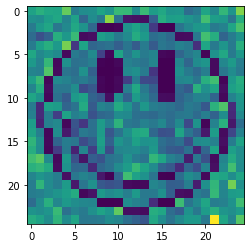

In [9]:
plt.imshow(img_dist) # WORKS!